# CS4379G Assignment 1 — Netflix Titles Analysis

## Research Questions
How has the number of titles added to Netflix changed over time (by year)?
Do Movies and TV Shows differ in typical duration (minutes vs. seasons) or in ratings
distribution?

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [2]:
df = pd.read_csv("../data/netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


## Quick Data Check

In [3]:
df.shape, df.columns
df.info()
df.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   show_id       8807 non-null   str  
 1   type          8807 non-null   str  
 2   title         8807 non-null   str  
 3   director      6173 non-null   str  
 4   cast          7982 non-null   str  
 5   country       7976 non-null   str  
 6   date_added    8797 non-null   str  
 7   release_year  8807 non-null   int64
 8   rating        8803 non-null   str  
 9   duration      8804 non-null   str  
 10  listed_in     8807 non-null   str  
 11  description   8807 non-null   str  
dtypes: int64(1), str(11)
memory usage: 825.8 KB


director        2634
country          831
cast             825
date_added        10
rating             4
duration           3
show_id            0
type               0
title              0
release_year       0
dtype: int64

## Data Dictionary (key columns)

type: Movie or TV Show

date_added: date the title was added to Netflix

year_added: extracted year from date_added (created in cleaning)

rating: maturity rating (e.g., TV-MA, PG-13)

listed_in: genre categories (comma-separated)

## Cleaning

In [4]:
# Basic cleaning
df = df.copy()

# Standardize column names (optional)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Parse date_added to datetime
df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")

# Create year_added for trends
df["year_added"] = df["date_added"].dt.year


## Helper Function(s)

In [5]:
# Helper: explode a comma-separated column into one item per row
def explode_list_column(dataframe, colname):
    s = dataframe[colname].fillna("").astype(str)
    exploded = (
        s.str.split(",")
         .explode()
         .str.strip()
    )
    out = dataframe.loc[exploded.index].copy()
    out[colname] = exploded
    out = out[out[colname] != ""]
    return out

## Analysis 1

In [6]:
titles_per_year = (
    df.dropna(subset=["year_added"])
      .groupby("year_added")
      .size()
      .sort_index()
)

titles_per_year.tail(10)

year_added
2012.0       3
2013.0      10
2014.0      23
2015.0      73
2016.0     418
2017.0    1164
2018.0    1625
2019.0    1999
2020.0    1878
2021.0    1498
dtype: int64

## Visualization 1 + Interpretation

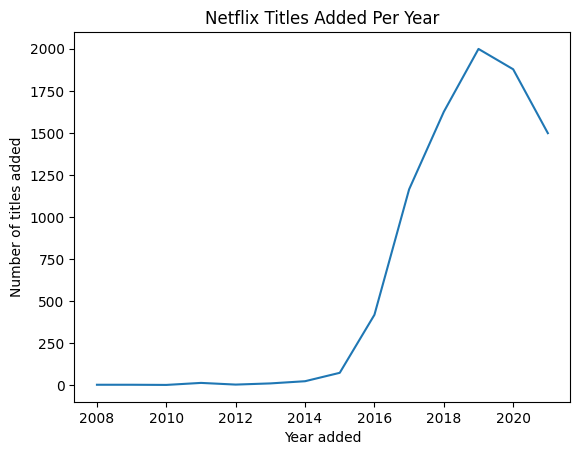

In [7]:
plt.figure()
plt.plot(titles_per_year.index, titles_per_year.values)
plt.title("Netflix Titles Added Per Year")
plt.xlabel("Year added")
plt.ylabel("Number of titles added")
plt.show()

# Interpretation:

The number of titles added grows slowly through the early years and then increases sharply starting around 2016. The peak occurs around 2019 (about 1999 titles), followed by a decline in 2020–2021. This suggests Netflix expanded its catalog aggressively in the late 2010s, then slowed somewhat afterward. A small number of missing date_added values may slightly affect counts, but the overall trend is clear.

## Analysis 2

In [8]:
ratings_by_type = (
    df.dropna(subset=["type", "rating"])
      .groupby(["type", "rating"])
      .size()
      .reset_index(name="count")
)

# Get top 10 ratings overall so the plot is readable
top_ratings = (
    df["rating"].value_counts().head(10).index
)

ratings_top = ratings_by_type[ratings_by_type["rating"].isin(top_ratings)]

pivot = ratings_top.pivot(index="rating", columns="type", values="count").fillna(0)

pivot
genres = explode_list_column(df, "listed_in")
top_genres = genres["listed_in"].value_counts().head(10)
top_genres


listed_in
International Movies        2752
Dramas                      2427
Comedies                    1674
International TV Shows      1351
Documentaries                869
Action & Adventure           859
TV Dramas                    763
Independent Movies           756
Children & Family Movies     641
Romantic Movies              616
Name: count, dtype: int64

# Interpretation for the genres table (helper function usage)

After exploding the comma-separated listed_in column, the most common category is International Movies (2752), followed by Dramas (2427) and Comedies (1674). This suggests Netflix’s catalog is heavily weighted toward international content and drama/comedy genres. Because each title can belong to multiple genres, these counts represent “genre tags” rather than unique titles.

## Visualization 2 + Interpretation

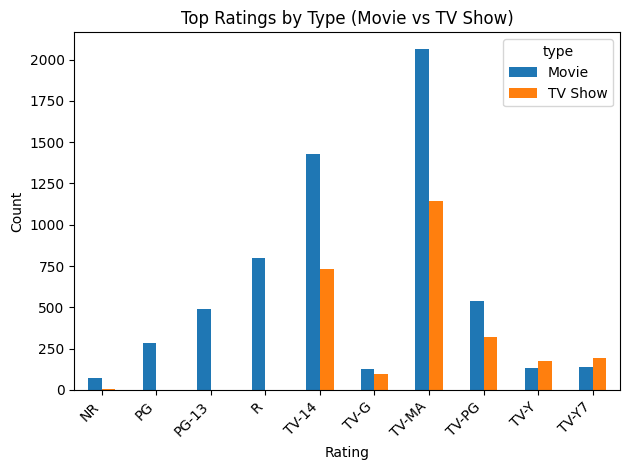

In [11]:
ax = pivot.plot(kind="bar")
ax.set_title("Top Ratings by Type (Movie vs TV Show)")
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Interpretation:

The rating distributions differ between Movies and TV Shows. Movies are strongly represented in film ratings like PG-13 and R, while TV Shows concentrate more in TV-specific ratings like TV-Y and TV-Y7. Both types peak at TV-MA and TV-14, suggesting a large share of Netflix content targets mature/teen audiences. The plot shows only the top ratings overall to keep the comparison readable.

## Conclusion

- Netflix titles added per year rise sharply starting around 2016, peaking around 2019, then declining somewhat in 2020–2021.

- Movies and TV Shows have different rating distributions: Movies dominate PG-13/R while TV Shows dominate TV-Y/TV-Y7; both peak at TV-MA/TV-14.

- Exploding listed_in shows the most common categories are International Movies, Dramas, and Comedies, indicating strong international and drama/comedy representation.

- Missing values in columns like country/director/cast limit deeper analysis unless additional cleaning is performed.